<a href="https://colab.research.google.com/github/BossBosssmile/AmpliGraph/blob/main/neo4j.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install neo4j 

     |████████████████████████████████| 89 kB 3.4 MB/s 
  Created wheel for neo4j: filename=neo4j-4.4.1-py3-none-any.whl size=114783 sha256=822d3d082e5b3122904b7f7e385af1a561a5ed7f51b4a30e43026321f07c9336
  Stored in directory: /root/.cache/pip/wheels/fd/15/02/8379f87426cd1b74fd5891f49df9fb978423feb97650cd639b
Successfully built neo4j


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from neo4j import GraphDatabase
from tqdm.notebook import tqdm_notebook

pd.set_option("max_columns", None)
pd.set_option("max_colwidth", None)
pd.set_option("max_rows", None)

## Import data 
In csv file the data is in triples <h, r, t> format.
We will import data into Dataframe in the columns ['head', 'relation', 'tail'] respectively.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/gdrive/MyDrive/'

In [ ]:
df = pd.read_csv('/data.csv', names=['head', 'relation', 'tail'])
df.head()

,head,relation,tail
0,P001,friend with,P002
1,P001,friend with,P006
2,P001,friend with,P008
3,P001,friend with,P011
4,P001,friend with,P012


Next, we want to know number of each relationship and unique node.

like           358
type of        305
is a           275
from            89
budget          65
player mode     50
use             47
friend with     34
part of         21
born in         14
based in         9
in league        9
Name: relation, dtype: int64


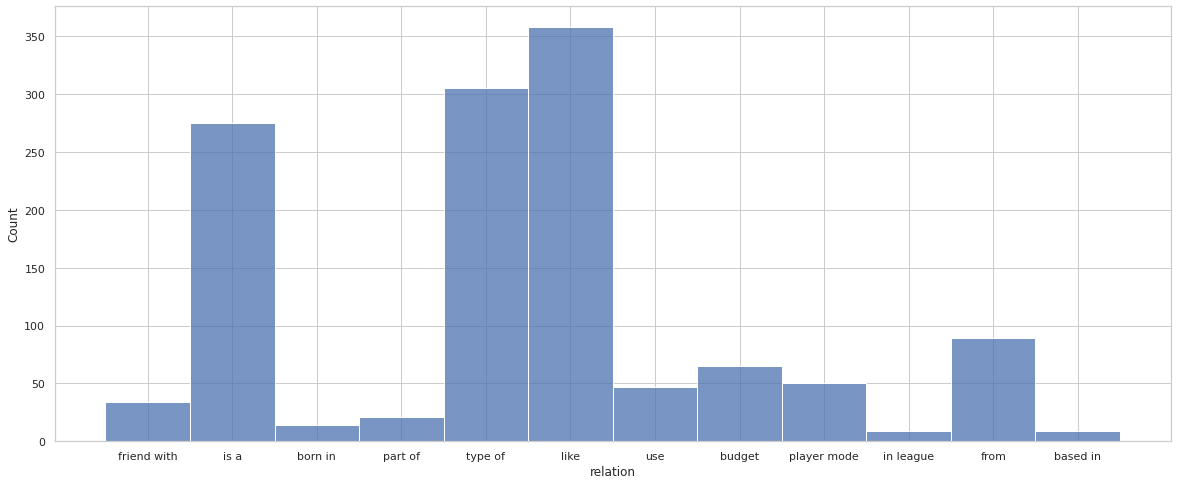

In [ ]:
print(df['relation'].value_counts())

sns.set_theme(rc = {'figure.figsize':(20,8)},
              style="whitegrid")
sns.histplot(data=df['relation'])

In [ ]:
print(f"Number of unique node: {pd.concat([df['head'],df['tail']]).nunique()}")

Number of unique node: 378


## Explore Node label

**Exploring the "is a" relationship, <h is a, t>, that means the node type in the head. Collected in `df_is_a` dataframe**

In [ ]:
df_is_a = df[df['relation'] == 'is a']
df_is_a

,head,relation,tail
34,P001,is a,PERSON
35,P002,is a,PERSON
36,P003,is a,PERSON
37,P004,is a,PERSON
38,P005,is a,PERSON
39,P006,is a,PERSON
40,P007,is a,PERSON
41,P008,is a,PERSON
42,P009,is a,PERSON
43,P010,is a,PERSON


**Search for all types of nodes.**

In [ ]:
type_is_a = df_is_a['tail'].unique()

print(f'Number of unique node types: {len(type_is_a)}')
print(type_is_a)

Number of unique node types: 17
['PERSON' 'PLACE' 'SOCIAL MEDIA' 'FOOD' 'PC GAME' 'MOBILE GAME'
 'BOARD GAME' 'FOOTBALL TEAM' 'BUFFET' 'SERIES' 'MOVIE' 'SINGER'
 'ACTOR/ACTRESS' 'SONGWRITER' 'MODEL' 'COUNTRY' 'CITY']


**Searches for nodes that have been assigned a type using a "is a" relationship, <h, is a, t>.**

In [ ]:
node_defined = df_is_a['head'].unique()

print(f'Number of unique node that defined type: {len(node_defined)}')

Number of unique node that defined type: 275


**Searches for another node that has not yet been assigned a type, where these nodes are minor type.**

In [ ]:
node_undefined = np.setdiff1d(pd.concat([df['head'],df['tail']], ignore_index=True), 
                              node_defined, 
                              assume_unique=False)

print(f'Number of unique node that defined type: {len(node_undefined)}')

Number of unique node that defined type: 103


**Assign a type to all nodes that are not yet defined as "TYPES" and append to `df_is_a` for assign node label in neo4j database.**

In [ ]:
df_is_a = df_is_a.append(pd.DataFrame([[i, 'is a', 'TYPES'] for i in np.concatenate((type_is_a, node_undefined), axis=None)], 
                                      columns=df_is_a.columns), 
                         ignore_index=True)

**Finally, we get a total of 18 node types (that means label in neo4j) to create database.**

In [ ]:
type_is_a = np.append('TYPES',type_is_a)

print(f'Number of unique node types: {len(type_is_a)}')
print(type_is_a)

Number of unique node types: 18
['TYPES' 'PERSON' 'PLACE' 'SOCIAL MEDIA' 'FOOD' 'PC GAME' 'MOBILE GAME'
 'BOARD GAME' 'FOOTBALL TEAM' 'BUFFET' 'SERIES' 'MOVIE' 'SINGER'
 'ACTOR/ACTRESS' 'SONGWRITER' 'MODEL' 'COUNTRY' 'CITY']


## Connect to neo4j

**We need to define a connection class to connect to the graph database**

In [ ]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

**Connect to neo4j**

In [ ]:
host = "bolt://3.239.105.70:7687"
user = "Nuttawat"
password = "1234"

# connect to neo4j
conn = Neo4jConnection(uri=host, user=user, pwd=password)

### Prepare kays for setup table of each node

In [ ]:
constraint_name = [i.lower().replace(' ', '_').replace('/', '_') for i in type_is_a]
short = ['type', 'person', 'place', 'media', 'food', 'pc', 'mobile', 'board', 'football', 'buffet', 
         'serie', 'movie', 'singer', 'actor', 'writer', 'model', 'country', 'city']
label_name = ['Types', 'Person', 'Place', 'Social_media', 'Food', 'PC_game', 'Mobile_game', 'Board_game', 'Football_team',
              'Buffet', 'TV_Series', 'Movie', 'Singer', 'Actors', 'Song_writer', 'Model', 'Country', 'City']
property_unique = ['type', 'person id', 'place name', 'social media', 'food name', 'pc game name', 'mobile game name', 
                   'board game name', 'football team name', 'buffet name', 'serie name', 'movie name', 'signer name', 
                   'actor/actress name', 'song writer name', 'model name', 'country name', 'city name']

create_lists = pd.DataFrame({'constraint_name': constraint_name, 
                             'short': short, 
                             'label_name': label_name,
                             'property_unique': property_unique
                            }, index=type_is_a)

create_lists

,constraint_name,short,label_name,property_unique
TYPES,types,type,Types,type
PERSON,person,person,Person,person id
PLACE,place,place,Place,place name
SOCIAL MEDIA,social_media,media,Social_media,social media
FOOD,food,food,Food,food name
PC GAME,pc_game,pc,PC_game,pc game name
MOBILE GAME,mobile_game,mobile,Mobile_game,mobile game name
BOARD GAME,board_game,board,Board_game,board game name
FOOTBALL TEAM,football_team,football,Football_team,football team name
BUFFET,buffet,buffet,Buffet,buffet name


### Create constraints constraints within the database that will ensure the nodes are not duplicates while also setting up some indexing.

In [ ]:
for ind, row in create_lists.iterrows():
    conn.query(f'''CREATE CONSTRAINT {row['constraint_name']} IF NOT EXISTS 
                   ON ({row['short']}:{row['label_name']}) 
                   ASSERT {row['short']}.identify_name IS UNIQUE
               ''')

### Add nodes

In [ ]:
persons = pd.DataFrame(df_is_a[df_is_a['tail'] == 'PERSON']['head']).to_dict('records')

In [ ]:
def add_nodes(data, short, label_name, property_unique):
    # Adds nodes to the Neo4j graph.
  
    query = f'''UNWIND $rows AS row 
            MERGE ({short}:{label_name} {{identify_name: row.head, identify_description: "{property_unique}"}})
            '''
    
    return conn.query(query, parameters={'rows': data.to_dict('records')})

In [ ]:
for ind, row in create_lists.iterrows():
    
    data = pd.DataFrame(df_is_a[df_is_a['tail'] == ind]['head'])

    add_nodes(data, row['short'], row['label_name'], row['property_unique'])

### Add relations

In [ ]:
def add_relations(data, label_name_h, label_name_t, relation):
    query = f'''UNWIND $rows as row
            MATCH 
                (h:{label_name_h} {{identify_name: row.head}}),
                (t:{label_name_t} {{identify_name: row.tail}})
            MERGE (h)-[:{relation}]->(t)
            '''
    
    return conn.query(query, parameters={'rows': data.to_dict('records')})

In [ ]:
for relation in tqdm_notebook(df['relation'].unique()):
    push_df = df[df['relation'] == relation]
    
    for ind_h, row_h in create_lists.iterrows():
        for ind_t, row_t in create_lists.iterrows():
            add_relations(push_df, 
                          row_h['label_name'], 
                          row_t['label_name'], 
                          relation.replace(' ', '_')
                         )

  0%|          | 0/12 [00:00<?, ?it/s]

### Neo4j to PyKEEN

In [ ]:
query = """
MATCH (s)-[r]->(t)
RETURN properties(s).identify_name as head, properties(t).identify_name AS tail, type(r) as relation
"""

a = conn.query(query); a

[<Record head='BANGKOK AND SURROUNDING' tail='THAILAND' relation='part_of'>,
 <Record head='INCEPTION' tail='ACTION' relation='type_of'>,
 <Record head='INCEPTION' tail='SCIENCE FICTION' relation='type_of'>,
 <Record head='INCEPTION' tail='ADVENTURE' relation='type_of'>,
 <Record head='NORTH OF THAILAND' tail='THAILAND' relation='part_of'>,
 <Record head='NORTHEAST OF THAILAND' tail='THAILAND' relation='part_of'>,
 <Record head='SOUTH OF THAILAND' tail='THAILAND' relation='part_of'>,
 <Record head='STARDEW VALLEY' tail='MULTIPLAYER GAME' relation='player_mode'>,
 <Record head='STARDEW VALLEY' tail='SINGLE-PLAYER GAME' relation='player_mode'>,
 <Record head='STARDEW VALLEY' tail='MEDIUM COST' relation='budget'>,
 <Record head='STARDEW VALLEY' tail='SIMULATION' relation='type_of'>,
 <Record head='STARDEW VALLEY' tail='INDIE' relation='type_of'>,
 <Record head='STARDEW VALLEY' tail='ROLE-PLAYING' relation='type_of'>,
 <Record head='VEGETABLE STEW' tail='LOCAL FOOD' relation='type_of'>,
 <

In [ ]:
df_r = pd.DataFrame(map(dict, a))
df_r.head()

,head,tail,relation
0,BANGKOK AND SURROUNDING,THAILAND,part_of
1,INCEPTION,ACTION,type_of
2,INCEPTION,SCIENCE FICTION,type_of
3,INCEPTION,ADVENTURE,type_of
4,NORTH OF THAILAND,THAILAND,part_of


In [ ]:
df_r = df_r.reindex(columns=['head', 'relation', 'tail'])
df_r.head()

,head,relation,tail
0,BANGKOK AND SURROUNDING,part_of,THAILAND
1,INCEPTION,type_of,ACTION
2,INCEPTION,type_of,SCIENCE FICTION
3,INCEPTION,type_of,ADVENTURE
4,NORTH OF THAILAND,part_of,THAILAND


### Neo4j to AmpliGraph

In [ ]:
query = """
MATCH (s)-[r]->(t)
RETURN properties(s).identify_name as head, properties(t).identify_name AS tail, type(r) as relation
"""

a = conn.query(query); a

[<Record head='BANGKOK AND SURROUNDING' tail='THAILAND' relation='part_of'>,
 <Record head='INCEPTION' tail='ACTION' relation='type_of'>,
 <Record head='INCEPTION' tail='SCIENCE FICTION' relation='type_of'>,
 <Record head='INCEPTION' tail='ADVENTURE' relation='type_of'>,
 <Record head='NORTH OF THAILAND' tail='THAILAND' relation='part_of'>,
 <Record head='NORTHEAST OF THAILAND' tail='THAILAND' relation='part_of'>,
 <Record head='SOUTH OF THAILAND' tail='THAILAND' relation='part_of'>,
 <Record head='STARDEW VALLEY' tail='MULTIPLAYER GAME' relation='player_mode'>,
 <Record head='STARDEW VALLEY' tail='SINGLE-PLAYER GAME' relation='player_mode'>,
 <Record head='STARDEW VALLEY' tail='MEDIUM COST' relation='budget'>,
 <Record head='STARDEW VALLEY' tail='SIMULATION' relation='type_of'>,
 <Record head='STARDEW VALLEY' tail='INDIE' relation='type_of'>,
 <Record head='STARDEW VALLEY' tail='ROLE-PLAYING' relation='type_of'>,
 <Record head='VEGETABLE STEW' tail='LOCAL FOOD' relation='type_of'>,
 <

In [ ]:
X = np.array([i.values() for i in a])
X

array([['BANGKOK AND SURROUNDING', 'THAILAND', 'part_of'],
       ['INCEPTION', 'ACTION', 'type_of'],
       ['INCEPTION', 'SCIENCE FICTION', 'type_of'],
       ...,
       ['LIVERPOOL', 'CITY', 'is_a'],
       ['PARIS', 'FRANCE', 'part_of'],
       ['PARIS', 'CITY', 'is_a']], dtype='<U42')